#SN Refsdal reduction and extraction

In this notebook I will do the scripting for reducing and extracting SN Refsdal. Additional notes and output will be in the corresponding Evernote.


In [1]:
# Setup plotting environment
%matplotlib inline
import matplotlib.pyplot as plt
# use seaborn for nice default plot settings
import seaborn as sns; sns.set_style('ticks')

In [2]:
# Importing manupulation packages
from astropy.io import fits
import numpy as np
import glob

In this code-block we will import the spectra in dictionaries, so that we can treat them individually through loops. The UVB and VIS arm contains 4 spectra and the NIR, two. This required some additional flow control statements which clutter the code a bit. We print the path to the input spectra.


In [18]:
#TODO mothodize this to make the code cleaner
arm = 'NIR'
binning = '50'
#nirmode = 'Stare'
nirmode = 'Nod'

if arm == 'VIS' or arm == 'UVB' or (arm == 'NIR' and nirmode == 'Stare'):
    if not arm == 'NIR':
        files = glob.glob('/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/STARE_reduction/'+arm+'/*/*/*/*FLUX_MERGE2D_*')
    elif arm == 'NIR':
        files = glob.glob('/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/STARE_reduction/'+arm+'/*/*/*/*MERGE2D_*')
elif arm == 'NIR' and nirmode == 'Nod':
    files = glob.glob('/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/NOD_quick/*/*/*/*2D_NIR*')
    #resp = glob.glob('/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/NOD_quick/*/*/*/*2D_NIR*')
    resp = fits.open('/Users/jselsing/github/SN_Refsdal_Reduction/M.XSHOOTER.2014-04-15T14:16:03.860.fits')
    resp = resp[1].data.field('RESPONSE')
    resp = np.tile(resp , (85, 1))

    
if arm == 'VIS' or arm == 'UVB' or (arm == 'NIR' and nirmode == 'Stare'):
    nam = ['1', '2', '3' , '4']
elif arm == 'NIR' and nirmode == 'Nod':
    nam = ['1', '2']
    
    
obs = {}


for i, n in enumerate(nam):
    print files[i]
    obs[n] = fits.open(str(files[i]))
    


#fitsfile = fits.open(str(files))

dats = {}
for n in nam:
    if arm == 'NIR':
        dats[n] = obs[n][0].data * resp * ( 2.12 / obs[n][0].header['EXPTIME'])
        continue
    dats[n] = obs[n][0].data
        
errs = {}
for n in nam:
    if arm == 'NIR':
        errs[n] = obs[n][1].data * resp * ( 2.12 / obs[n][0].header['EXPTIME'])
        continue
    errs[n] = obs[n][1].data * resp
    
bpmaps = {}
for n in nam:
    bpmaps[n] = obs[n][2].data
    
heads = {}
for n in nam:
    heads[n] = obs[n][0].header

shps = {}
for n in nam:
    shps[n] = np.shape(dats[n])

xs = {}
for n in nam:
    xs[n] = np.arange(shps[n][1])
    
ys = {}
for n in nam:
    ys[n] = np.arange(shps[n][0])
    

    

/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/NOD_quick/reflex_end_products/2015-05-21T16:06:42/XSHOO.2015-05-16T00:09:16.846_tpl/Refsdal_S1S2_1_SCI_SLIT_MERGE2D_NIR.fits
/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/NOD_quick/reflex_end_products/2015-05-21T16:06:42/XSHOO.2015-05-16T00:52:35.694_tpl/Refsdal_S1S2_1_SCI_SLIT_MERGE2D_NIR.fits


In this section we will estimate the sky for the UVB and VIS arm. This is done by masking the regions containing signal and for the rest calculate a sigma-clipped mean along the spatial direction, which is then subtracted for each pixel along the entire wavlength array.

In [4]:
#Estimate sky


from astropy.stats import sigma_clip

skydats = {}

if arm == 'UVB':
    centers = [8, 53, 28,73]
elif arm == 'VIS':
    centers = [8, 53, 28, 73]
elif arm == 'NIR':
    centers = [8, 44, 26, 62]


for i, n in enumerate(nam):
    edge_mask = np.logical_or( (ys[n] < 5),(ys[n] > max(ys[n]) -5))

    center = centers[i]
    width = 5

    pos1 = int(2.5 / heads[n]['CD2_2'])
    pos2 = int(4.3 / heads[n]['CD2_2'])

    wsn = 5

    trace_mask = np.logical_and((ys[n] > center - width),(ys[n] < center + width))

    pos1_mask = np.logical_and((ys[n] > center - pos1 - wsn),(ys[n] < center - pos1 + wsn))
    pos2_mask = np.logical_and((ys[n] > center - pos2 - wsn),(ys[n] < center - pos2 + wsn))


    mask = np.logical_or(np.logical_or(np.logical_or(trace_mask, edge_mask), pos1_mask), pos2_mask)


    full_mask = np.tile(mask , (len(xs[n]), 1)).T

    bpmask = (bpmaps[n] != 0)

    tot_mask = np.logical_or(full_mask, bpmask)

    dataarr = np.ma.array(dats[n], mask=tot_mask)

    sky_spectrum_clip = sigma_clip(dataarr, sig = 2,  axis=0, iters=None, copy = True, cenfunc=np.ma.median, varfunc=np.ma.var)

    sky_spectrum = np.ma.mean(sky_spectrum_clip, axis=0)

    sky_dat = np.zeros(np.shape(dats[n]))
    for k in np.arange(len(sky_dat[:,0])):
        sky_dat[k, :] = sky_spectrum
    skydats[n] = sky_dat

    
skysubs = {}

#for n in nam:
#    skysubs[n] = dats[n] - skydats[n]

if arm == 'VIS' or arm == 'UVB' or (arm == 'NIR' and nirmode == 'Stare'):
    for n in nam:
        skysubs[n] = dats[n] - skydats[n]
        
elif arm == 'NIR' and nirmode == 'Nod':
    for n in nam:
        skysubs[n] = dats[n]

In [5]:
def weighted_avg_and_std(values, sigma, axis=0):
    
    norm = abs(np.ma.mean(values))
    #print norm
    values = np.ma.array(values) / norm
    sigma = np.ma.array(sigma) / norm


    
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy masked ndarrays with the same shape.
    """

    
    weight = 1.0 / (sigma ** 2.0)
    average, sow = np.ma.average(values, weights = weight, axis = axis, returned = True)
    #variance = 1.0 / np.ma.sum(weight , axis = axis )
    variance = 1.0 / sow
    return ((average * norm).data, (np.sqrt(variance)*norm).data ) 
    
    
    #var = sigma**(-2.0)
    #weighted_average = np.ma.sum( values * var , axis = axis) / np.ma.sum( var , axis = axis)
    #weighted_average_variance = 1.0 / np.ma.sum(var, axis = axis)
    #corrected_weighted_average_variance = weighted_average_variance * \
    #                                      ((1.0 / (np.ma.sum(array_mask, axis=axis) - 1.0))) * \
    #                                     np.ma.sum(((values - weighted_average)**2)/ sigma**2, axis = axis)
    #return (weighted_average.data, np.sqrt(corrected_weighted_average_variance.data)) 
 



In [6]:

cumoffy = []


if arm == 'VIS' or arm == 'UVB' or (arm == 'NIR' and nirmode == 'Stare'):
    for i, n in enumerate(nam):
        offsety = int(heads[n]['HIERARCH ESO SEQ CUMOFF Y'] / heads[n]['CD2_2'])
        #Correct for drifting pointing (This will change depending on your observations)
        if i >= 2:
            offsety -= int(2.92 / heads[n]['CD2_2'])
        cumoffy.append(offsety)
elif arm == 'NIR' and nirmode == 'Nod':
    for i, n in enumerate(nam):
        offsety = 0.0
        if i >= 1:
            offsety -= int(2.92 / heads[n]['CD2_2'])
        cumoffy.append(offsety)
cumoffy = np.array(cumoffy) 

print cumoffy




[  0. -13.]


In [19]:
#TODO
# Right now WCS information is wrong. 
#

def combine_spectra(nam, fluxs, errs, bpmaps, cumoffy, outfile ='your_combined_data.fits'):

    flux = []
    sigma = []
    qual = []

    

    for i, n in enumerate(nam):
        
                
        
        #Defining size of out-array
        v_size = shps[n][0] + (abs(max(cumoffy)) - min(cumoffy))
        h_size = shps[n][1]

        #Masking 1 pixel edges in individual frames.
        edge_mask = (ys[n] > max(ys[n]) -1) | (ys[n] < min(ys[n]) + 1)
        full_mask = np.tile(edge_mask , (len(xs[n]), 1)).T
        
        #Defining positional offset between the frames.
        pos_v, pos_h = cumoffy[i], 0  # offset
        
        #b1 is full-size container with all values masked and b2 is input image with edge-mask + bad pixel mask.
        b1 = np.ma.array(np.zeros((v_size, h_size)), mask = True)
        b2 = np.ma.array(fluxs[n], mask = full_mask)
        
        #Finding the indices of the container in which to put image.
        offv = (abs(max(cumoffy)) - abs(min(cumoffy)))  - min(cumoffy)   - pos_v      
        v_range1 = slice( v_size - shps[n][0] - offv  ,    v_size - offv  )
        offh = 0 - pos_h      
        h_range1 = slice( h_size - shps[n][1] - offh  ,    h_size - offh  )
        
        # Insert smaller (b3, input image) frame into larger frame (container)
        b1[v_range1, h_range1] = b2
        
        #Append to list containing flux images
        flux.append(b1)
        
        #Repeat for error extension
        b3 = np.ma.array(np.zeros((v_size, h_size)), mask = True)
        b4 = np.ma.array(errs[n], mask = full_mask)
        b3[v_range1, h_range1] = b4
        sigma.append(b3)
        
        #Repeat for bad pixel map 
        b5 = np.ma.array(np.zeros((v_size, h_size)), mask = True)
        b6 = np.ma.array(bpmaps[n], mask = full_mask)
        b5[v_range1, h_range1] = b6
        qual.append(b5)  
        

    print 'Combining to file: '+outfile+''

    for i, n in enumerate(flux):
        #Combine edge-mask and bad pixel mask
        mask = (qual[i] != 0) | ((flux[i].mask) & (sigma[i].mask) & (qual[i].mask))
        
        #Construct masked arrays
        flux[i] = np.ma.array(flux[i], mask=mask)
        sigma[i] = np.ma.array(sigma[i], mask=mask)
        qual[i] = np.ma.array(qual[i], mask=mask)
    
    
    #Find the file number belonging to the image with smallest cumoffy (the one that starts at  (0, 0))
    wrf = str(np.argmin(cumoffy) + 1)
    #Calculate weighted average and variance
    obs[wrf][0].data, obs[wrf][1].data = weighted_avg_and_std(flux, sigma, axis=0)
    
    #Sum over bad pixels (should be 0 everywhere)
    obs[wrf][2].data = np.ma.sum(qual, axis=0).data
 
    obs[wrf].writeto(outfile, clobber =True)
    
    return obs[wrf]


comb = combine_spectra(nam, skysubs, errs, bpmaps, cumoffy, outfile ='SN_Refsdal'+arm+'.fits')


Combining to file: SN_RefsdalNIR.fits


<matplotlib.colorbar.Colorbar instance at 0x10e5ccd88>

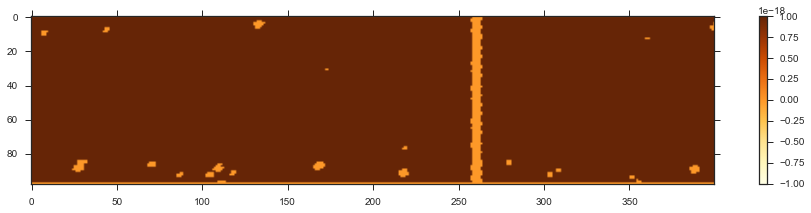

In [9]:
fig, ax = plt.subplots(figsize = (16, 3))
#plt.imshow(comb[1].data[:, 10500:10700], vmin=-10, vmax=10, cmap='YlOrBr', origin='lower')
plt.imshow(comb[1].data[:, 19500:19900], vmin=-10e-19, vmax=10e-19, cmap='YlOrBr')
plt.colorbar()   

(-1e-18, 1e-18)

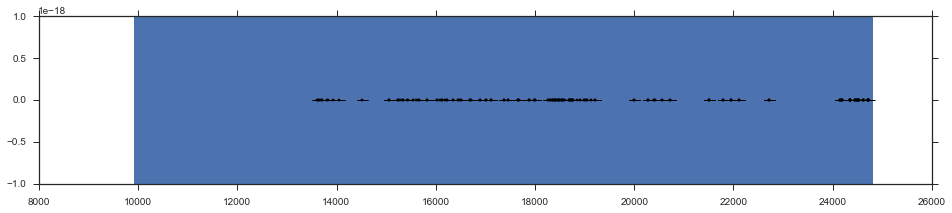

In [10]:
spec, err = weighted_avg_and_std(comb[0].data[28:31, :],  comb[1].data[28:31, :],  axis = 0)
fig, ax = plt.subplots(figsize = (16, 3))
wave = 10.*(np.arange(comb[0].header['NAXIS1'])*comb[0].header['CDELT1']+comb[0].header['CRVAL1'])

plt.plot(wave, spec, drawstyle='steps-mid')
plt.errorbar(wave, spec, yerr=err, fmt='o', marker='o', capsize=5.5, ms=2, mew=0.5, color='black', elinewidth=0.5)
plt.ylim((-1e-18, 1e-18))
#plt.xlim((10000, 20000))

In [20]:
def bin_image(img,binx,biny):
    import numpy as np
    from gen_methods import wmean
    
    
    mask = np.zeros(np.shape(img[0].data)).astype(bool)
    mask[:,10640:10680] = np.ones(np.shape(img[0].data[:, 10640:10680])).astype(bool)
    mask[:,4190:4210] = np.ones(np.shape(img[0].data[:, 4190:4210])).astype(bool)
    

    img[0].data = np.ma.array(img[0].data, mask = mask)
    #return
    
    """
    Used to bin low S/N 2D data from xshooter.
    Calculates the weigted averages of the bins, using the weighted average.
    Returns binned 2dimage
    """

    if binx == 1 and biny == 1:
        return img
    
    #Outsize
    s=np.shape(img[0].data)
    outsizex=s[0]/binx
    outsizey=s[1]/biny

    #Containers
    res = np.zeros((outsizex,outsizey))
    reserr = np.zeros((outsizex,outsizey))
    bpmap = np.zeros((outsizex,outsizey))

    for i in np.arange(0,s[0]-(binx+1),binx):
         for j in np.arange(0,s[1]-(biny+1),biny):
            #We sigma-clip 5-sigma outliers along the binning direction.
            flux_clip = sigma_clip(img[0].data[i:i+binx,j:j+biny], sig = 5,  axis=1, iters=None, copy = True, \
                                   cenfunc=np.ma.median, varfunc=np.ma.var)
            #Construct weighted average and weighted std
            res[((i+binx)/binx-1),((j+biny)/biny-1)], reserr[((i+binx)/binx-1),((j+biny)/biny-1)] = \
                        weighted_avg_and_std(flux_clip, img[1].data[i:i+binx,j:j+biny], axis = 1)
            #Sum bad pixel bad (should be only zeroes by now)
            bpmap[((i+binx)/binx-1),((j+biny)/biny-1)] = np.ma.sum(img[2].data[i:i+binx,j:j+biny], axis = 1)

    #Update header information
    img[0].header['NAXIS'] = 2
    img[0].header['NAXIS1'] = outsizey
    img[0].header['NAXIS2'] = outsizex
    img[0].header['CDELT1'] = img[0].header['CDELT1']*biny 
    img[0].header['CDELT2'] = img[0].header['CDELT2']*binx 
    img[0].header['CD2_2'] = img[0].header['CD2_2']*binx
    img[0].header['CD1_1'] = img[0].header['CD1_1']*biny 
    img[0].data = res
    img[1].data = reserr
    img[2].data = bpmap  

    
    return img


print('Binning...')
#binning = str(100)
#comb = fits.open('/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/NOD_quick/reflex_end_products/2015-05-21T16:06:42/XSHOO.2015-05-16T00:52:35.694_tpl/Refsdal_S1S2_1_SCI_SLIT_MERGE2D_NIR.fits')    
#comb = fits.open('/Users/jselsing/Work/X-Shooter/Frontier-Fields/SN_Refsdal/NOD_quick/reflex_end_products/2015-05-21T16:06:42/XSHOO.2015-05-16T00:09:16.846_tpl/Refsdal_S1S2_1_SCI_SLIT_MERGE2D_NIR.fits')    


comb_bin = bin_image(comb, 1, int(binning))
name = 'SN_Refsdal'+arm+'binned'+binning+'.fits'
comb_bin.writeto(name, clobber=True)
print('Done. Writing to '+name)

Binning...
Done. Writing to SN_RefsdalNIRbinned50.fits


#In this seciton we will investigate the 1D spectrum

Awesome stuff going on.

(51, 54)
(60, 63)


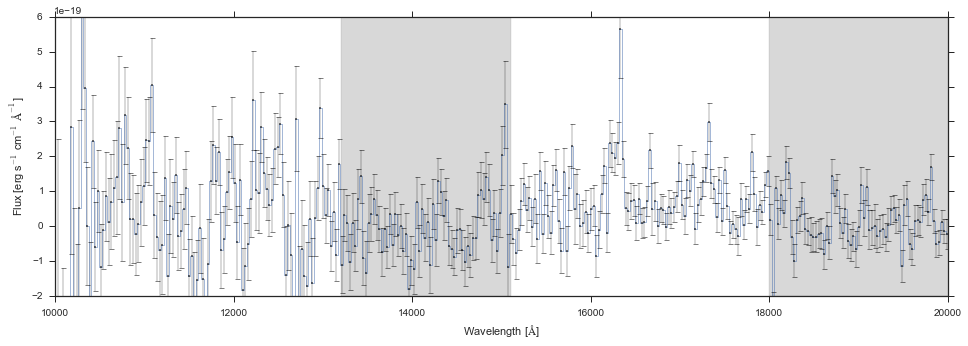

In [33]:

comb_bin = fits.open('SN_RefsdalNIRbinned50.fits')
#comb_bin = fits.open('SN_RefsdalNIRbinned50NOD1.fits')
#resp = fits.open('/Users/jselsing/github/SN_Refsdal_Reduction/M.XSHOOTER.2014-04-15T14:16:03.860.fits')
#resp = resp[1].data.field('RESPONSE')
wave = 10.*(np.arange(comb_bin[0].header['NAXIS1'])*comb_bin[0].header['CDELT1']+comb_bin[0].header['CRVAL1'])




#middle1 = 38.2
middle1 = 53.4
dist = 1.5
lower1 = int(middle1 - dist)
upper1 = int(middle1 + dist)
print(lower1, upper1)

#middle2 = 48.8
middle2 = 61.9
lower2 = int(middle2 - dist)
upper2 = int(middle2 + dist)
print(lower2, upper2)


sn_pos1 = comb_bin[0].data[lower1:upper1, :]
sn_pos2 = comb_bin[0].data[lower2:upper2, :]

sn_pos1_err = comb_bin[1].data[lower1:upper1, :]
sn_pos2_err = comb_bin[1].data[lower2:upper2, :]

combined_sn_pos = np.vstack((sn_pos1, sn_pos2))
combined_sn_pos_err = np.vstack((sn_pos1_err, sn_pos2_err)) 

spec, err = weighted_avg_and_std(combined_sn_pos, combined_sn_pos_err,  axis = 0)


#lower3 = 23
#upper3 = 29

lower3 = 30
upper3 = 40

spec_host, err_host = weighted_avg_and_std(comb_bin[0].data[lower3:upper3, :], comb_bin[1].data[lower3:upper3, :],  axis = 0)



#msk = (wave > 16000) & (wave < 16500)

spec -= spec_host
err = np.sqrt(err**2 + (err_host)**2)

fig, ax = plt.subplots(figsize = (16, 5))


#flux = spec_host
#err = err_host


plt.plot(wave, spec, drawstyle='steps-mid', lw = 0.5)
plt.errorbar(wave, spec, yerr=err, fmt='o', marker='o', capsize=2.5, ms=1, mew=0.5, color='black', elinewidth=0.3)
plt.axvspan(13200, 15100, facecolor='grey', alpha=0.3)
plt.axvspan(18000, 21000, facecolor='grey', alpha=0.3)

plt.ylim((-2e-19, 6e-19))
#plt.ylim((-3, 10))
plt.xlim((10000, 20000))
#plt.xlim((15500, 17000))
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#plt.tight_layout()
#plt.savefig('SN_posHa.pdf')
plt.savefig('SN_pos_hostsub.pdf', dpi = 2400)